# TTT4185 Machine learning for Speech technology

## Voluntary computer assigment 1: Speech analysis

This assignment assumes that the student has knowledge about short-time spectral estimation, linear prediction modeling and cepstral analysis. You should also know the concept of fundamental frequencies and formants.

Useful commands include `matplotlib.pyplot.plot`.

### Problem 1

In this problem we will look at a speech signal and do simple spectral analysis on the signal.

(a) Download the speech file `stry.wav` from Blackboard and load the file using `scipy.io.wavefile.read`. The speech represents the latter half of the English word "tapestry". The phonetic transcription is /s/ /t/ /r/ /iy/.
- Plot the signal.
- What is characteristic about the sounds /s/, /t/, /r/ and /iy/?
- Take a 40 millisecond subset of the vowel /iy/ and plot it.
- Find the fundamental frequency $F_0$ of the vowel.

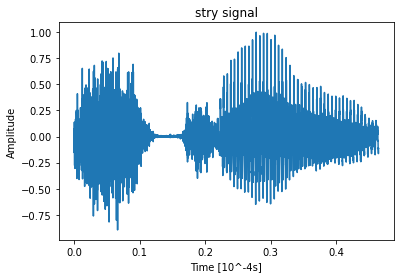

In [1]:
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np

Fs, data = scipy.io.wavfile.read('stry.wav')
#Normalizing the data
data = data / np.max(data)
n_samples = data.shape[0]
time = np.arange(0, n_samples)/Fs


plt.figure(1)
plt.title('stry signal')
plt.xlabel('Time [10^-4s]')
plt.ylabel('Amplitude')
plt.plot(time, data)
plt.show()

- We observe that the sounds /s/ and /iy/ have the biggest amplitudes and thus the most energy. Usually, /s/ wouldnt have this large amplitudes as it is not voiced, but as it follows an 'e' in the word 'tapestry', I assume the energy from the 'e' effects the energy of the /s/. Neither /t/ nor /r/ are voiced, which reflects in the small amplitude rash.

640


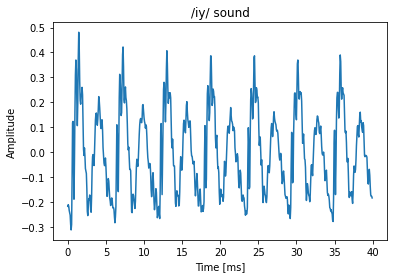

In [2]:
# Plotting /iy/: We see from the plot that this sound takes place from around 600 ms. 
# The end is then at 40 milliseconds * the sampling rate

N = int(40*0.001*Fs)
print(N)
vowel = data[6000:6000 + N];


plt.figure()
plt.title('/iy/ sound')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')
plt.plot(np.array(range(0, 640))*1000/Fs, vowel)
plt.show()

- There are approximately a total of 7 periods within the 40 ms. This gives a fundamental frequency of 175 Hz.

(b) Spectral analysis
- Estimate the spectrum of the vowel using an FFT of length 1024. Plot the log-spectrum as a function of frequency
- Multiply the signal by a Hamming window and repeat the last operation.
- Explain the difference between the two spectra.
- Estimate the fundamental frequency $F_0$ using the spectrum, and compare the result to what you got in 1a)
- Roughly estimate the two first formant frequencies.

Useful Python functions: `numpy.fft.fft`, `numpy.abs`, `scipy.signal.hamming`.

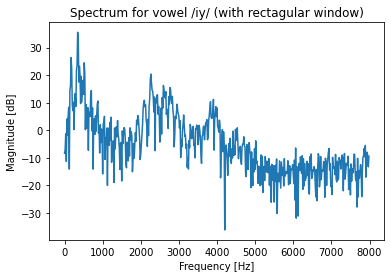

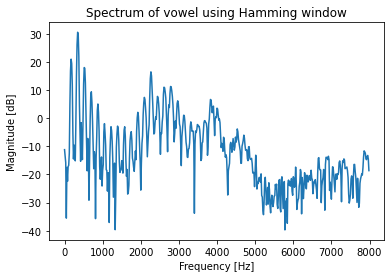

In [3]:
import scipy.signal

n = 1024
vowelFreqRect = np.fft.fft(vowel, n) # frequency response of the vowel with the rectangular window
plt.figure()
plt.plot(np.array(range(0, 512))/512*(Fs/2), 20*np.log10(np.abs(vowelFreqRect[0:512,])))
_ = plt.title('Spectrum for vowel /iy/ (with rectagular window)')
_ = plt.xlabel('Frequency [Hz]')
_ = plt.ylabel('Magnitude [dB]')

plt.figure()
vowelFreqHamming = np.fft.fft(vowel*np.hamming(N), n) # frequency response of the vowel with the Hamming window
plt.plot(np.array(range(0, 512))/512*(Fs/2), 20*np.log10(np.abs(vowelFreqHamming[0:512,])))
_ = plt.title('Spectrum of vowel using Hamming window')
_ = plt.xlabel('Frequency [Hz]')
_ = plt.ylabel('Magnitude [dB]')


- We observe that the spectrum of the windowed signal is a lot smoother than the non-windowed. It is much easier to see the individual peaks. This is a perk of using other windows than the rectangular window; it introduces a low-pass effect which reduces the amplitudes of discontinuities in the signal. 
- There appears to be 6 periods within 1000 Hz, which places the fundamental frequency at 167 Hz, not far from the 150 we found in a).
- The first two broadest peaks represent the two first formant frequencies, which is rougly 300 Hz and 2000 Hz. 


(c) AR modeling
- Compute the coefficients of an AR model (linear prediction coefficients) with order 4, 8, 16 and 50, based on the vowel.
- Estimate the spectrum for each of the model orders. Plot the log-spectrum as a function of frequency.
- Compare your results with the spectrum from 1b). Which model order yields the "best" spectral envelope? What happens if the model order is too high or too low?
- Why is it impossible to estimate the fundamental frequency based on the LP model?

Useful Python functions: `pysptk.sptk.lpc`, `scipy.signal.freqz`.

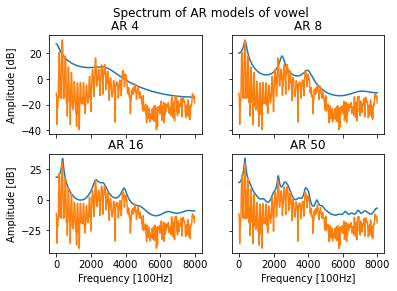

In [4]:
import math
def my_lpc(y, m):
    "Return m linear predictive coefficients for sequence y using Levinson-Durbin prediction algorithm"
    #compute autoregression coefficients R_0, ..., R_m
    R = [y.dot(y)] 
    if R[0] == 0:
        return [1] + [0] * (m-2) + [-1]
    else:
        for i in range(1, m + 1):
            r = y[i:].dot(y[:-i])
            R.append(r)
        R = np.array(R)
    #step 2: 
        A = np.array([1, -R[1] / R[0]])
        E = R[0] + R[1] * A[1]
        for k in range(1, m):
            if (E == 0):
                E = 10e-17
            alpha = - A[:k+1].dot(R[k+1:0:-1]) / E
            A = np.hstack([A,0])
            A = A + alpha * A[::-1]
            E *= (1 - alpha**2)
        return A

ar_4 = my_lpc(vowel, 4)
ar_8 = my_lpc(vowel, 8)
ar_16 = my_lpc(vowel, 16)
ar_50 = my_lpc(vowel, 50)

w_4, h_4 = scipy.signal.freqz(1, ar_4)
w_8, h_8 = scipy.signal.freqz(1, ar_8)
w_16, h_16 = scipy.signal.freqz(1, ar_16)
w_50, h_50 = scipy.signal.freqz(1, ar_50)

fig, ims = plt.subplots(2,2)
fig.suptitle('Spectrum of AR models of vowel')
ims[0, 0].set_title('AR 4')
ims[0, 0].plot(w_4*8000/np.pi, 20*np.log10(abs(h_4)))
# Plot spectrum also
ims[0, 0].plot(w_4*8000/np.pi, 20*np.log10(np.abs(vowelFreqHamming[0:512,])))

ims[0, 1].set_title('AR 8')
ims[0, 1].plot(w_8*8000/np.pi, 20*np.log10(abs(h_8)))
ims[0, 1].plot(w_8*8000/np.pi, 20*np.log10(np.abs(vowelFreqHamming[0:512,])))

ims[1, 0].set_title('AR 16')
ims[1, 0].plot(w_16*8000/np.pi, 20*np.log10(abs(h_16)))
ims[1, 0].plot(w_16*8000/np.pi, 20*np.log10(np.abs(vowelFreqHamming[0:512,])))

ims[1, 1].set_title('AR 50')
ims[1, 1].plot(w_50*8000/np.pi, 20*np.log10(abs(h_50)))
ims[1, 1].plot(w_50*8000/np.pi, 20*np.log10(np.abs(vowelFreqHamming[0:512,])))

for im in ims.flat:
    im.set(xlabel='Frequency [100Hz]', ylabel='Amplitude [dB]')

for im in ims.flat:
    im.label_outer()


- The spectrums looks very different from eachother, but we can recognize the features of 1.b). It seems though that the AR 8 is the closest to a good spectral envelope for the spectrum. If the order is too low, a lot of the peaks are neglected and we get high prediction errors. If the order is too high, we are fitting the individual harmonics which leads to low prediction errors, but then we are modelling the source and not the spectral envelope. 

- It is impossible to estimate the fundamental frequency from the LP model because the small periodic lobes disappear. This is because the LPC coefficients only moel the filter, not the source (that contains f0) But, in a good spectral envelope, we can see the formants F1..Fn. 
 

(d) Use `scipy.signal.spectrogram` to create a spectrogram of the entire speech signal. Try to generate both wide- and narrow-band spectrograms by adjutinf the window lengths and overlaps. Which characteristic traits of the speech sounds /s/, /t/, /r/ and /iy/ can you see from the spectrogram?

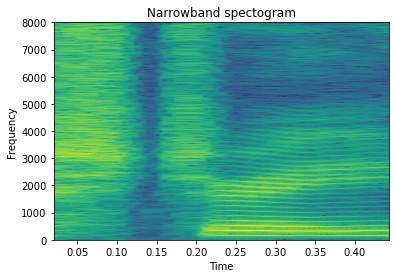

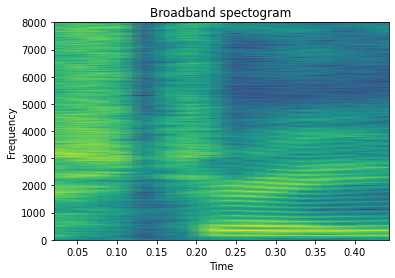

In [5]:
#(x, fs=1.0, window='tukey', 0.25, nperseg=None, 
#noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, mode='psd')

plt.figure()
fNB, tNB, SxxNB = scipy.signal.spectrogram(data, Fs, noverlap = 600, nperseg = 650, nfft = 1024) # choosing a long enough window 
plt.pcolormesh(tNB, fNB, 20*np.log10((SxxNB)), shading='gouraud')
_ = plt.title('Narrowband spectogram')
_ = plt.ylabel('Frequency')
_ = plt.xlabel('Time')

plt.figure()
f, t, Sxx = scipy.signal.spectrogram(data, Fs, noverlap = 200, nperseg = 650, nfft = 1024)
plt.pcolormesh(t, f, 20*np.log10((Sxx)), shading='gouraud')
_ = plt.title('Broadband spectogram')
_ = plt.ylabel('Frequency')
_ = plt.xlabel('Time')


Which characteristic traits of the speech sounds /s/, /t/, /r/ and /iy/ can you see from the spectrogram?

- Tydelige vertikale linjer for iy - typisk for vokal. Representerer lobsene
- Gjenkenner formantene i starten ved iy
- Ser også vertikale linjer i r-delen - indikerer at det er peiodisitet i signalet. Ser ikke dette i s og t.
- Flatere spektrum for konsonantene. Vi ser også vertikale linjer hele veien, som viser hurtig overgang i amplitude når stemmebåndene klapper sammen.

### Problem 2
In this problem we look at the cepstrum and deconvolution

(a) Compute and plot the real cepstrum of the vowel from problem 1a).

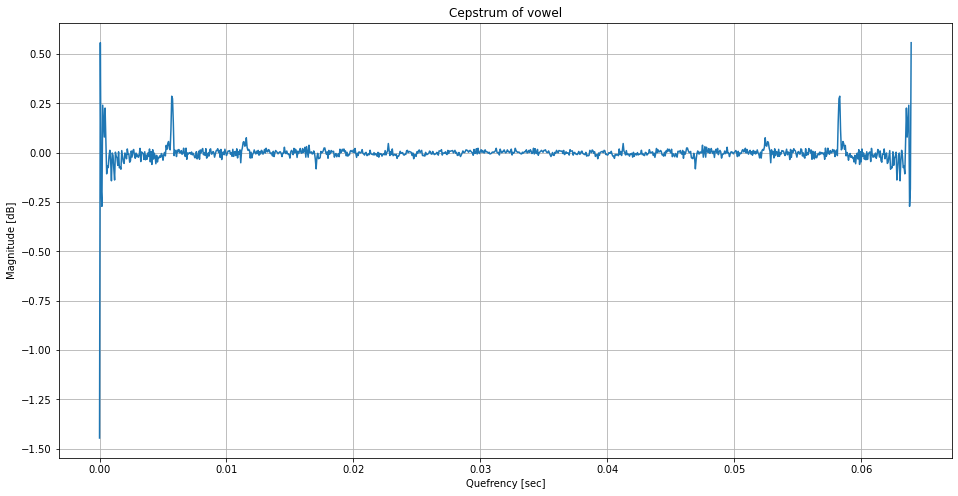

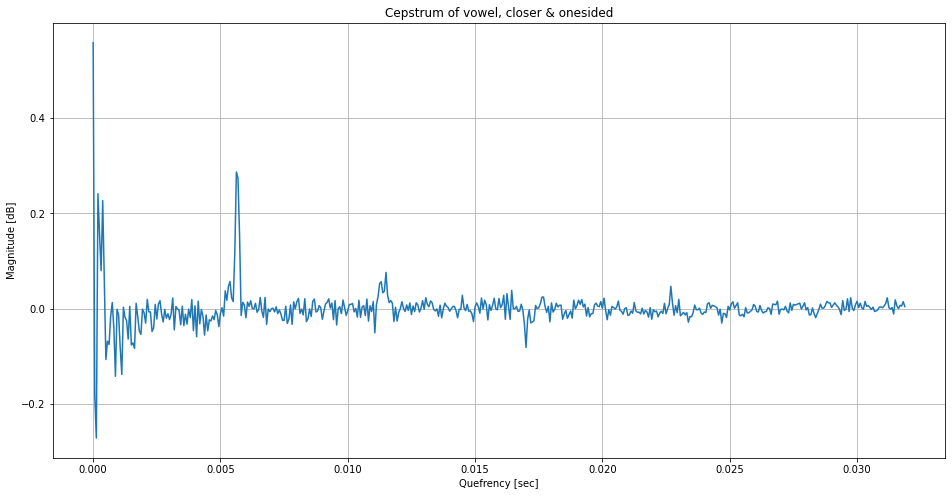

In [38]:
cep = np.fft.ifft(np.log(np.abs(vowelFreqHamming)))

plt.figure(figsize=(16, 8))
plt.plot(np.array(range(0,cep.shape[0]))/Fs, np.real(cep))
_ = plt.title('Cepstrum of vowel')
_ = plt.xlabel('Quefrency [sec]')
_ = plt.ylabel('Magnitude [dB]')
plt.grid()

plt.figure(figsize=(16, 8))
plt.plot(np.array(range(0,cep[1:512].shape[0]))/Fs, np.real(cep[1:512]))
_ = plt.title('Cepstrum of vowel, closer & onesided')
_ = plt.xlabel('Quefrency [sec]')
_ = plt.ylabel('Magnitude [dB]')
plt.grid()


(b) Use the cepstrum to compute the fundamental frequency $F_0$. Compare your results with those obtained in problem 1).

# When we find the cepstrum of the signal, we try to separate the source and the filter. Because the source and the filter are convoluted together, we need to do a homomorphic transform to separate the two. The source is a pulse train consisting of glottal pulses, and the filter is comprised of the vocal tract effects, resulting in a transferfunction. Because the spectrum of the filter is more slowly varying than the spectrum of the source, we observe that the main contribution in the cepstrum from the filter is in the low quefrency domain, whereas the contributions from the source is highly regular and faster, thus comprising a peak at higher quefrency.

In [21]:
# The largest peak after the filter contribution in the start:

# By inspection we estimate that the filter contribution stops around n = 20.

idx = np.argmax(cep[20:512]) + 21
print(idx)

# F0 = Fs/n

print('F0 from cepstrum = ', Fs/idx)


92
F0 from cepstrum =  173.91304347826087


This is approximately the same as in problem 1. a). 

(c) In this subproblem you will use the cepstrum to estimate the spectral envelope
- Use liftering to extract the part of the ceptrum that represents the spectral envelope.
- Plot the spectral envelope as a function of frequency, and compare the result with the results from problem 1).

Hint 1: Remember that the cepstrum of a real signal is symmetric, so the liftered signal mus be symmetric as well.

Hint 2: The FFT of a real, symmtric signal is real, but due to round-off errors small imaginary noise may occur. Use `np.real` to get to the real part of the liftered log-spectrum.

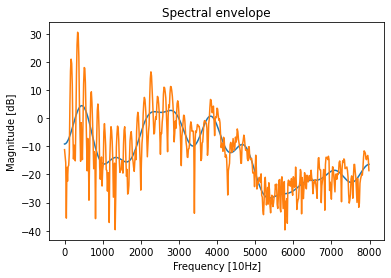

In [31]:
# Manuall liftering: remove the values in the middle that is not from the filter.

cep[20:-20] = 0

cep_w_ft = np.abs(np.exp(np.fft.fft(cep, n = 1024)))
#np.abs(np.exp(np.fft.fft(truncated_cepstr)))
envelope = (cep_w_ft[0:512])

plt.figure()
plt.title('Spectral envelope')
plt.xlabel('Frequency [10Hz]')
plt.ylabel('Magnitude [dB]')
plt.plot(np.array(range(0, 512))/512*(Fs/2), 20*np.log10(envelope))
plt.plot(np.array(range(0, 512))/512*(Fs/2), 20*np.log10(np.abs(vowelFreqHamming[0:512,])))
plt.show()